In [1]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath

import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


In [2]:
def temperature_scaling(logits, y):
    def temperature_obj(t):
        temp_logits = logits / (t )
        return log_loss(y, temp_logits)
    
    res = minimize_scalar(temperature_obj)
    return logits / (res.x )

In [3]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [4]:
logpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.dev_preds")


In [5]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=20)
    return prob_true, prob_pred


In [88]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

In [6]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [7]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [8]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return   np.exp(p)/(1 + np.exp(p))

In [9]:
with open(logpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [10]:
testpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [11]:
mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

In [12]:
gold0 =   np.array(M['golds'],dtype = int)
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)


In [13]:
tp= np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

In [14]:
tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)
tgold0 =   np.array(M_test['golds'],dtype = int)

In [68]:
def temperature_multi(p1, p2,p3,p4, 
                      y1, y2, y3, y4):
    def temperature_obj(t):
        logi_1 = (p1) + t[1] 
        logi_2 = (p2) + t[2]
        logi_3 = (p3) + t[3] 
        logi_4 = (p4) + t[4] 
        
        probs1  = expit (  (  logi_1/ t[0] ) )  *t[5]
        probs2  = expit ( (  logi_2/ t[0] )  )* t[5]
        probs3  = expit (  (  logi_3/ t[0] ) ) * t[5]
        probs4  = expit ( ( logi_4/ t[0]) )  * t[5]
        
        total_loss= log_loss(y1, probs1)+ log_loss(y2,probs2)+log_loss(y3,probs3)+log_loss(y4,probs4)
        return  total_loss
    r = minimize (temperature_obj, x0 = [2, .1, .1,.1, .1, .1] )
    
    #normed =  expit( r.x[0] * np.concatenate([p1/r.x[1], p2/r.x[2], p3/r.x[3], p4/r.x[4]]))  
    return  r

In [69]:
L1 =   (mp1)
L2 =  (mp2)
L3 =  (mp3)
L4 =  (mp4)

In [70]:
tt  = temperature_multi(    L1, L2, L3, L4,
                      gold1, gold2, gold3, gold4)

In [77]:
def temp_pred  (tt, j,  test_logit):
    logi = test_logit + tt.x[j] 
    
    proba = expit (  (  logi/ tt.x[0] ) ) #*tt.x[5]
    
    #cal_i = expit ( proba )
    return proba

(array([1821., 1278., 1007.,  944.,  864.,  854.,  996., 1203., 1737.,
        5325.]),
 array([0.07829158, 0.17045207, 0.26261256, 0.35477305, 0.44693354,
        0.53909403, 0.63125453, 0.72341502, 0.81557551, 0.907736  ,
        0.99989649]),
 <BarContainer object of 10 artists>)

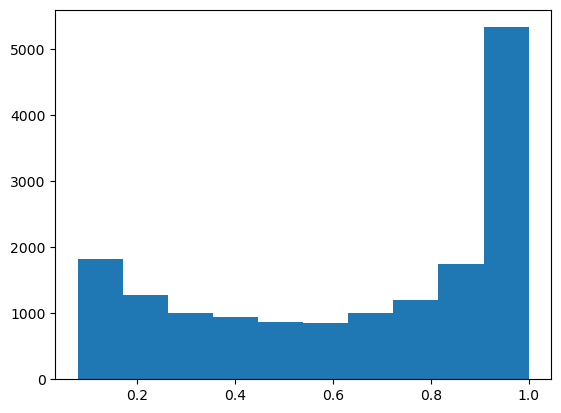

In [89]:
plt.hist( temp_pred (tt, 1,  L1 ))

In [90]:
ct1 =   temp_pred (tt, 1,  tp1 ) 

In [91]:
y1, p1 = compute_calibration_curve(M_test1['golds'], ct1 )
#y2, p2 = compute_calibration_curve(M_test2['golds'], ct2 )
#y3, p3 = compute_calibration_curve(M_test3['golds'], ct3 )
#y4, p4 = compute_calibration_curve(M_test4['golds'], ct4 )


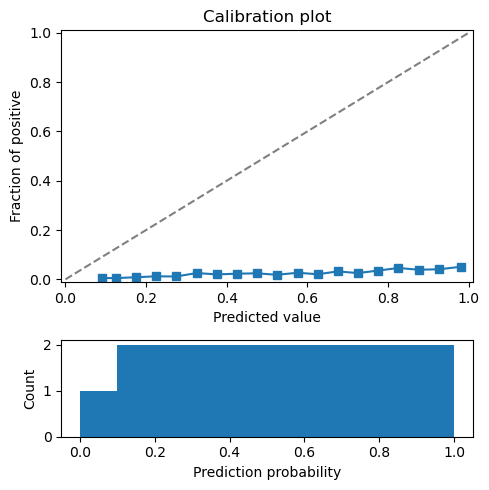

In [92]:
plotter(p1, y1)

In [20]:
def temp_pred_GEV (tt, j,  test_logit):
    p = test_logit
    z = (p + tt.x[j] )/tt.x[0]
    proba  = expit ( - (z+ np.exp(- z) )) #*  tt.x[5]
    #cal_i = expit ( proba )
    return proba

(array([1616., 1656., 1776., 1937., 2150., 2319., 2148., 1628.,  704.,
          95.]),
 array([0.0028939 , 0.02336606, 0.04383821, 0.06431037, 0.08478252,
        0.10525467, 0.12572683, 0.14619898, 0.16667114, 0.18714329,
        0.20761545]),
 <BarContainer object of 10 artists>)

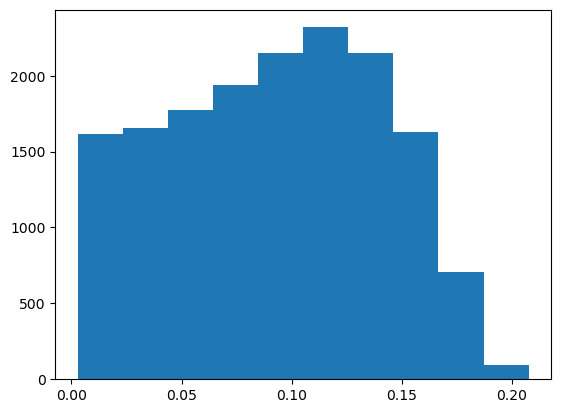

In [21]:
plt.hist( temp_pred_GEV(tt, 1, logit(mp1)) )

In [16]:
def temperature_scaling2(logits, y):
    def temperature_obj(t):
        temp_logits = logits / (t[0] ) + t[1]
        probs  = expit(temp_logits)
        return log_loss(y, probs)
    
    res = minimize (temperature_obj, x0 = [20,1.5] )
    normed = logits /res.x[0] + res.x[1]
    
    return  normed, res

In [17]:
def temperature_GEV (p1, p2,p3,p4, 
                      y1, y2, y3, y4):
    def temperature_obj(t):
        z_1 = (p1 + t[1] )/t[0]
        z_2 = (p2 + t[2])/t[0]
        z_3 = (p3 + t[3])/t[0]
        z_4 = (p4 + t[4])/t[0]
        
        probs1  =expit ( - (z_1+ np.exp(- z_1) )) *  t[5]
        probs2  = expit ( - (z_2+ np.exp(- z_2) )) *  t[5]
        probs3  = expit ( - (z_3+ np.exp(- z_3) )) *  t[5]
        probs4  = expit ( - (z_4+ np.exp(- z_4) )) *  t[5]
        
        total_loss= log_loss(y1, probs1)+ log_loss(y2,probs2)+log_loss(y3,probs3)+log_loss(y4,probs4)
        return  total_loss
    r = minimize (temperature_obj, x0 = [2, .1, .1,.1, .1, .1] )
    
    #normed =  expit( r.x[0] * np.concatenate([p1/r.x[1], p2/r.x[2], p3/r.x[3], p4/r.x[4]]))  
    return  r

In [18]:
tt  = temperature_GEV( logit(mp1), logit(mp2), logit(mp3), logit(mp4),    gold1, gold2, gold3, gold4)

In [19]:
tt.x

array([ 3.01748899, -2.11470998, -2.16262529, -2.28969375, -2.4571331 ,
        0.34910096])

(array([1629., 1706., 1908., 2056., 2302., 2380., 2124., 1349.,  516.,
          59.]),
 array([0.00623605, 0.05667243, 0.1071088 , 0.15754518, 0.20798156,
        0.25841793, 0.30885431, 0.35929068, 0.40972706, 0.46016344,
        0.51059981]),
 <BarContainer object of 10 artists>)

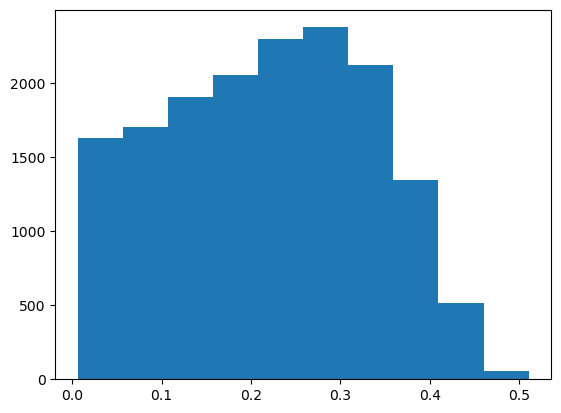

In [61]:
plt.hist(  np.exp ( - np.exp(  -  (logit(mp1) + tt.x[1] )/ tt.x[0]) )    )

(array([2926., 2554., 2441., 2347., 1906., 1122.,  553.,  175.,   22.,
           6.]),
 array([0.0062906 , 0.05023539, 0.09418017, 0.13812496, 0.18206974,
        0.22601453, 0.26995931, 0.3139041 , 0.35784888, 0.40179367,
        0.44573845]),
 <BarContainer object of 10 artists>)

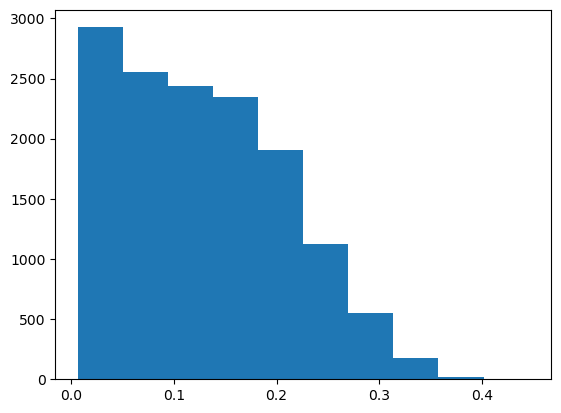

In [60]:
plt.hist(  np.exp ( - np.exp(  -  (logit(mp2) + tt.x[2] )/ tt.x[0]) )    )

(array([5.082e+03, 3.149e+03, 2.356e+03, 1.687e+03, 9.360e+02, 5.070e+02,
        2.330e+02, 8.400e+01, 1.300e+01, 5.000e+00]),
 array([0.00919766, 0.08153369, 0.15386972, 0.22620575, 0.29854178,
        0.3708778 , 0.44321383, 0.51554986, 0.58788589, 0.66022192,
        0.73255795]),
 <BarContainer object of 10 artists>)

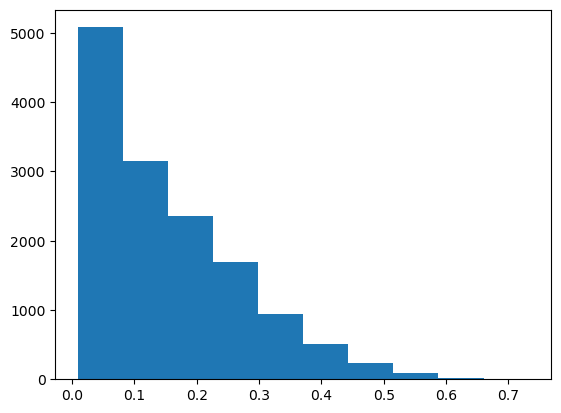

In [27]:
plt.hist(   expit( (logit(mp2)/tt.x[0] + tt.x[2])  )   )

(array([7.298e+03, 3.030e+03, 1.304e+03, 5.320e+02, 2.130e+02, 7.200e+01,
        2.000e+01, 1.000e+01, 1.000e+00, 1.000e+00]),
 array([0.00830551, 0.07243489, 0.13656426, 0.20069363, 0.26482301,
        0.32895238, 0.39308176, 0.45721113, 0.52134051, 0.58546988,
        0.64959925]),
 <BarContainer object of 10 artists>)

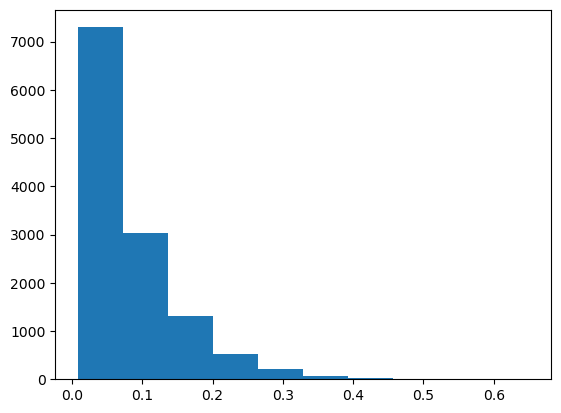

In [28]:
plt.hist(   expit( (logit(mp3)/tt.x[0] + tt.x[3])  )   )

(array([2.103e+03, 3.155e+03, 2.811e+03, 2.180e+03, 1.355e+03, 6.110e+02,
        2.100e+02, 4.500e+01, 1.000e+01, 1.000e+00]),
 array([0.0824083 , 0.1297896 , 0.17717091, 0.22455222, 0.27193352,
        0.31931483, 0.36669614, 0.41407744, 0.46145875, 0.50884006,
        0.55622137]),
 <BarContainer object of 10 artists>)

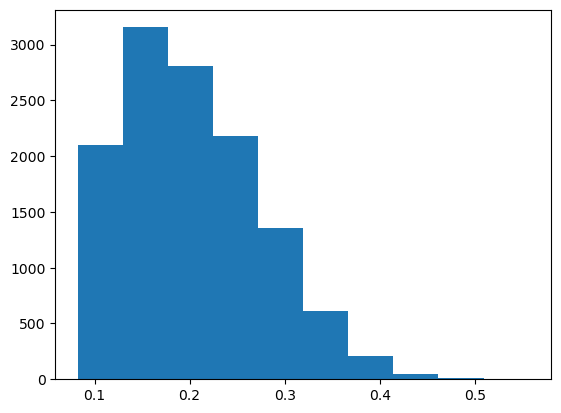

In [23]:
plt.hist(   expit( (logit(mp3)/tt.x[4] + tt.x[0])  )   )

In [29]:
ct1 =  expit( (logit(tp1)/tt.x[0] + tt.x[1]) )     
ct2 =  expit( (logit(tp2)/tt.x[0] + tt.x[2]) )     
ct3 =  expit( (logit(tp3)/tt.x[0] + tt.x[3]) )     
ct4 =  expit( (logit(tp4)/tt.x[0] + tt.x[4]) )     

In [30]:
y1, p1 = compute_calibration_curve(M_test1['golds'], ct1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], ct2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], ct3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], ct4 )


In [31]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

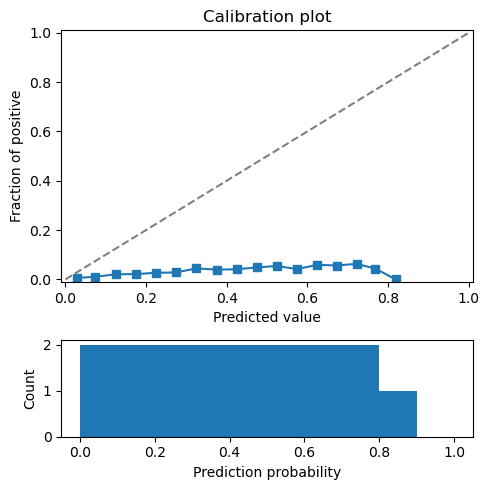

In [32]:
plotter(p1, y1)

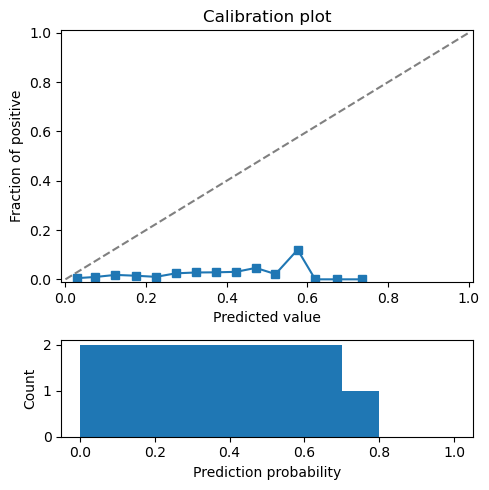

In [33]:
plotter(p2, y2)

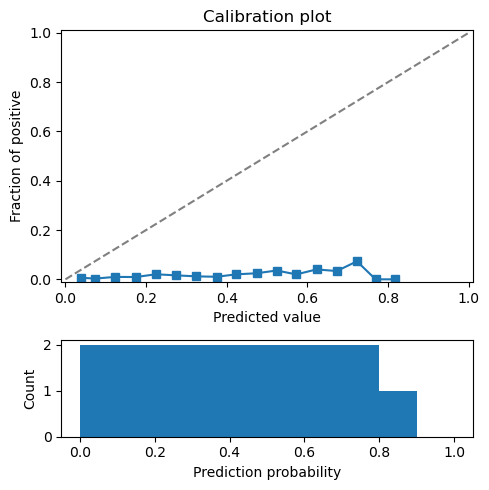

In [106]:
plotter(p2, y2)

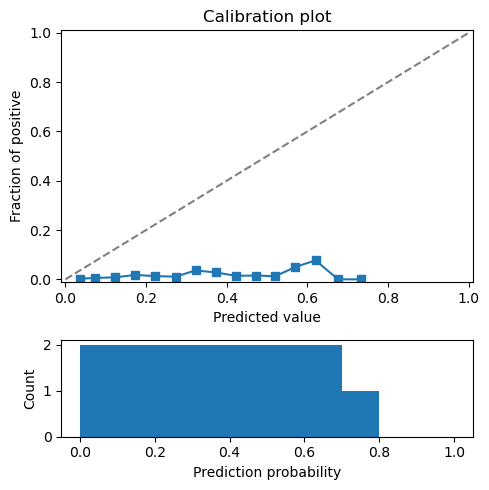

In [107]:
plotter(p3, y3)

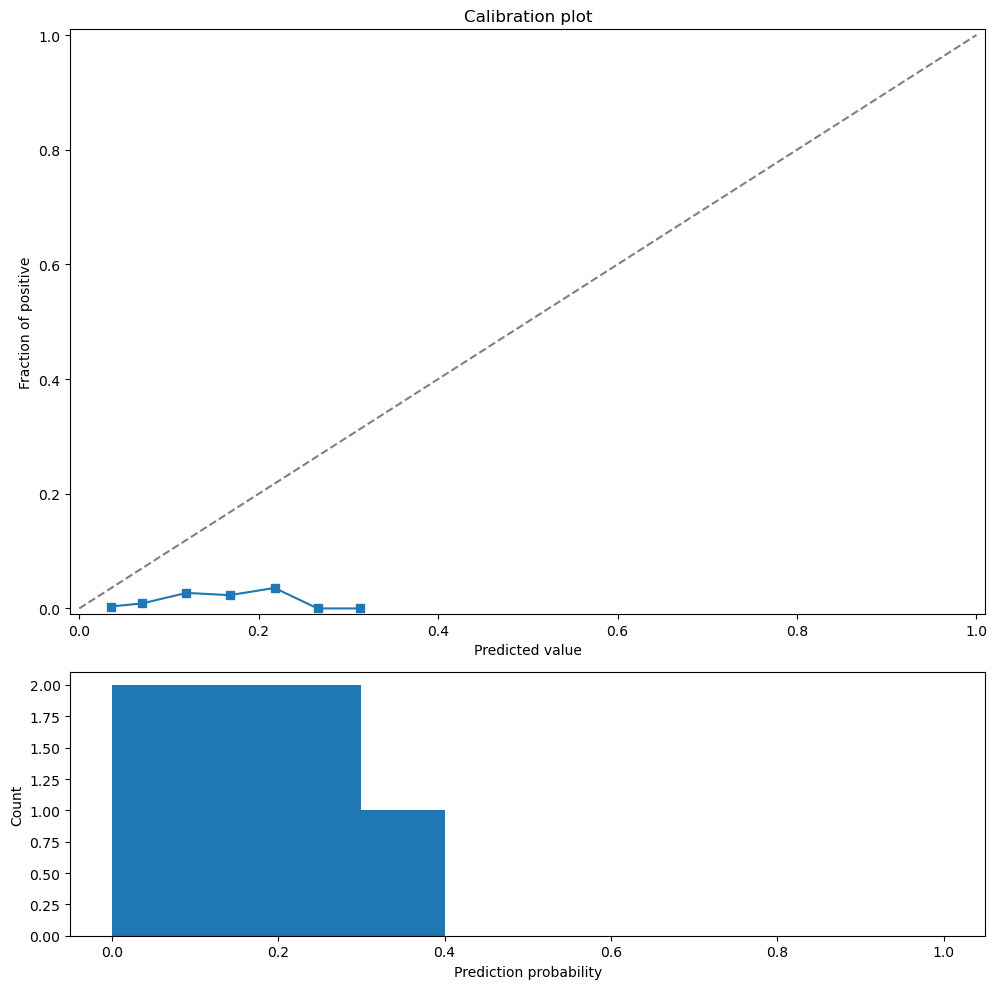

In [273]:
plotter(p4, y4)

(array([2451., 2792., 2698., 2569., 2145., 1737., 1021.,  459.,  146.,
          11.]),
 array([0.01589061, 0.06250444, 0.10911827, 0.1557321 , 0.20234593,
        0.24895976, 0.29557359, 0.34218742, 0.38880124, 0.43541507,
        0.4820289 ]),
 <BarContainer object of 10 artists>)

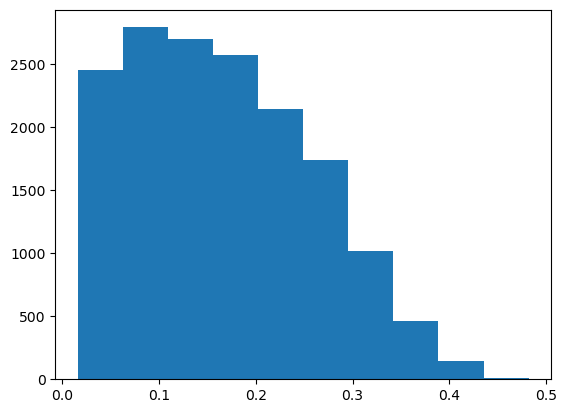

In [53]:
plt.hist( M1['probs'].to_numpy())

In [ ]:
sklearn.metrics.roc_auc_score(m1['outcome'],  m1['p6'], average = 'samples')


0.5600783435183764

In [ ]:
( confusion_matrix (m1['outcome'],  m1['p6']>.5) )

array([[72681,     5],
       [ 4301,     0]], dtype=int64)

In [ ]:
# how many people had event within 6 months of index date

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 

In [39]:
y1 = np.array(M1['golds'],dtype = int)
x1 = M1['probs'].to_numpy()
platt.fit(x1, y1)
cal_1 = platt.predict(M_test1['probs'])